# Learning over Text
Brandeis University COSI 104A Spring 25
Professor Dylan Cashman

In this notebook, we will learn a few methods of building a machine learning model that takes text as input.

We will largely be following the example of sentiment analysis on the IMDB dataset of movie reviews as presented in Raschka Chapter 8.  *Sentiment Analysis* involves predicting if a document is expressing positive sentiment ("I liked the movie!") or negative sentiment ("Terrible acting, what a waste of time").  If we have an appropriate representation of each review within a vector space, we would expect positive reviews to be separable from negative reviews.

First, we'll load the data, preprocess it.  Then we'll explore it a little.  For more information, read through Raschka Chapter 8.

In [2]:
# Download the data (~100 mb).  Should take 30-60 seconds.
import os
import requests
import tarfile
# Create the data directory if it doesn't exist
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

# Define the URL of the dataset and the output file path
url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
output_path = os.path.join(data_dir, "aclImdb_v1.tar.gz")

print(f"Downloading data from: {url}")
print(f"Saving to: {output_path}")

try:
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an exception for bad status codes

    with open(output_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

    print(f"Successfully downloaded and saved to: {output_path}")

    # Optional: Extract the tar.gz file
    extraction_path = os.path.join(data_dir, "aclImdb")
    os.makedirs(extraction_path, exist_ok=True)

    print(f"Extracting data to: {extraction_path}")
    with tarfile.open(output_path, "r:gz") as tar:
        tar.extractall(extraction_path)

    print(f"Successfully extracted to: {extraction_path}")

except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")
except tarfile.ReadError as e:
    print(f"Error reading the tar.gz file: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Saving to: data/aclImdb_v1.tar.gz
Successfully downloaded and saved to: data/aclImdb_v1.tar.gz
Extracting data to: data/aclImdb


/var/folders/l_/lp31dhb10vd9kh0s1nl5j_sr0000gn/T/ipykernel_34929/1485153708.py:32: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extraction_path)


Successfully extracted to: data/aclImdb


In [1]:
# Next, we load it into a pandas dataframe.  We are using a few packages to report to us the speed, since this can be a slow process.

import pyprind
import pandas as pd
import os
import sys
basepath = 'data/aclImdb/aclImdb'

# Note that I do this a little differently than the textbook because
# df.append has been deprecated for good reasons (https://stackoverflow.com/a/75956237)
rows = []
labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000, stream=sys.stdout)
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
                rows.append([txt, labels[l]])
                # df = df.append([[txt, labels[l]]], ignore_index=True)
                pbar.update()

df = pd.DataFrame(rows)
df.columns = ['review', 'sentiment']

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


In [2]:
print(df.shape)
print(df.head())
df.describe()

(50000, 2)
                                              review  sentiment
0  I went and saw this movie last night after bei...          1
1  Actor turned director Bill Paxton follows up h...          1
2  As a recreational golfer with some knowledge o...          1
3  I saw this film in a sneak preview, and it is ...          1
4  Bill Paxton has taken the true story of the 19...          1


,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [3]:
# Next, we will convert each review into a Bag of Words.

# First, we have to do some preprocessing.
# 1. Remove punctuation and fix some emoticons

import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text

df['review'] = df['review'].apply(preprocessor)

print(df.head())


<>:9: SyntaxWarning: invalid escape sequence '\)'
<>:10: SyntaxWarning: invalid escape sequence '\W'
<>:9: SyntaxWarning: invalid escape sequence '\)'
<>:10: SyntaxWarning: invalid escape sequence '\W'
/var/folders/l_/lp31dhb10vd9kh0s1nl5j_sr0000gn/T/ipykernel_42081/3829978453.py:9: SyntaxWarning: invalid escape sequence '\)'
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
/var/folders/l_/lp31dhb10vd9kh0s1nl5j_sr0000gn/T/ipykernel_42081/3829978453.py:10: SyntaxWarning: invalid escape sequence '\W'
  text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))


                                              review  sentiment
0  i went and saw this movie last night after bei...          1
1  actor turned director bill paxton follows up h...          1
2  as a recreational golfer with some knowledge o...          1
3  i saw this film in a sneak preview and it is d...          1
4  bill paxton has taken the true story of the 19...          1


In [4]:
# 3. Next, we will create our Bag of Words
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()

docs = count.fit_transform(df['review'])
docs.shape


(50000, 104083)

In [5]:
# We end up with a vocabulary of 104,083.  This isn't great - we probably have a lot of low information words.  In addition, our model will have a lot of trouble learning in this space.  Let's shrink this to a max number of words.  But let's see if we can learn in this space.

count = CountVectorizer(max_features=5000)

docs = count.fit_transform(df['review'])
docs.shape

(50000, 5000)

Confusion matrix:
[[10859  1594]
 [ 1553 10994]]
Accuracy: 0.87412


/Users/dylancashman/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


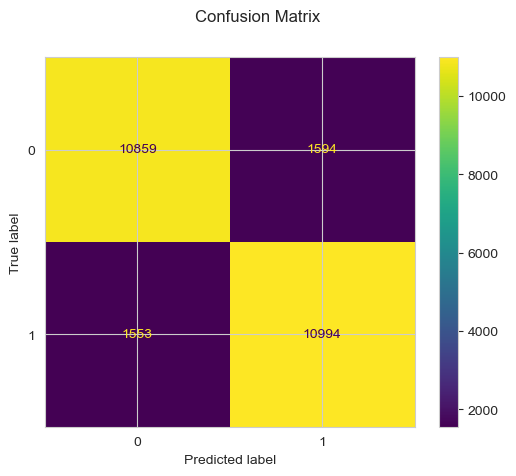

In [26]:
from sklearn import datasets, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

clf = LogisticRegression()

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    docs, df.sentiment, test_size=0.5, shuffle=True
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

print(f"Accuracy: {metrics.accuracy_score(y_test, predicted)}")


Well - it did pretty well - 87\% accuracy.  Let's see if the projection shows anything here as well.

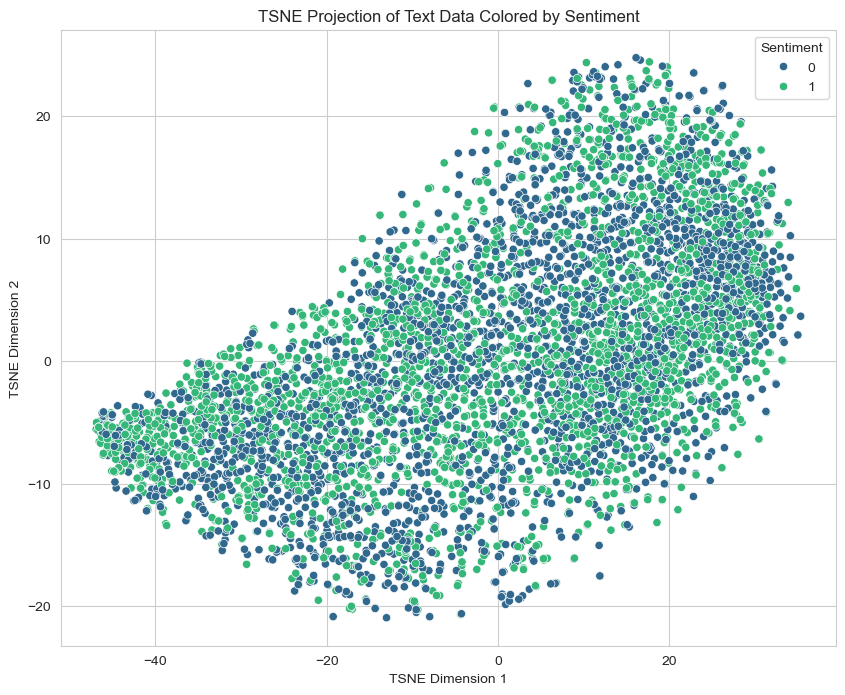

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
n_components = 2  # We want a 2D projection
tsne = TSNE(n_components=n_components, random_state=42, perplexity=30, init="random")
tsne_projection = tsne.fit_transform(X_train[:5000])
tsne_df = pd.DataFrame(data=tsne_projection, columns=['TSNE1', 'TSNE2'])
tsne_df['sentiment'] = y_train[:5000].values

plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='sentiment', data=tsne_df, palette='viridis')
plt.title('TSNE Projection of Text Data Colored by Sentiment')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()

It doesn't seem very separable.  This illustrates that the high dimensional space doesn't have quite enough information about sentiment to allow us to see it in the projection.  It also illustrates that tSNE is not always going to give us what we want.